In [1]:
# IMPORTS

In [2]:
import numpy as np
import json
import random
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
from sklearn import linear_model
import re

In [3]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import SGD

In [4]:
# Read in data initial

In [5]:
# Function for reading in the json files
def parseJSON(filename):
    with open(filename) as data_file:
        data = json.load(data_file)
    return data

In [6]:
data = parseJSON("merged_file.json")

In [7]:
# Take all the data from each queue and put it in one list
allData = []
for queue in data:
    for line in queue:
        allData.append(line)

In [8]:
allData[0]

{u'accepted_at': 1448896319000,
 u'avg_wait_for_day': 496.0,
 u'course': u'CSE12',
 u'created_at': 1448895823000,
 u'daily_ticket_count': 1.0,
 u'day_of_week': 0.0,
 u'diff': 496000,
 u'position': 0.0,
 u'ticket_id': 30671.0,
 u'time_of_day': u'15:03:43',
 u'time_to_resolve': 3771000,
 u'tutor_id': 6410.0,
 u'tutors_on_duty': []}

In [9]:
# Preprocess data

In [10]:
# Convert the average wait time for each day to milliseconds adn convert the created at feature to a datetime
for line in allData:
    line['avg_wait_for_day'] = int(line['avg_wait_for_day'] * 60 * 1000)
    if type(line['created_at']) is int:
        line['created_at'] = datetime.datetime.fromtimestamp(int(line['created_at'])/1000).strftime('%Y-%m-%d')

In [11]:
# Get the average time it took to resolve a ticket per day for a queue
resolution_time = defaultdict(list)
resolution_tickets = defaultdict(int)

for line in allData:
    if not line['time_to_resolve'] is None:
        resolution_time[line['created_at'] + line['course']].append((line['daily_ticket_count'],line['time_to_resolve'])) 
        resolution_tickets[line['created_at'] + line['course']] += 1

running_daily_avg = dict()
for day in resolution_time:
    resolution_time[day].sort()
    recentTickets = [720000] * 5
    
    # Keep a queue of the last 10 tickets get rid of outliers
    for ticket in resolution_time[day]:
        if ticket[1] / (60*1000) >= 5 and ticket[1] / (60*1000) <= 45:
            recentTickets.append(ticket[1])
        if len(recentTickets) > 10:
            recentTickets.pop(0)
        running_daily_avg[day+str(ticket[0])] = sum(recentTickets) * 1.0 / len(recentTickets)

avg_resolution_time = dict()
for day in resolution_time:
    avg_resolution_time[day] = sum([b for a, b in resolution_time[day]]) / resolution_tickets[day]
    
tutorStats = defaultdict(int)
ticketCount = defaultdict(int)

for line in allData:
    if not line['time_to_resolve'] is None:
        tutorStats[line['tutor_id']] += (line['time_to_resolve'] * 1.0
                                        / avg_resolution_time[line['created_at'] + line['course']])
        ticketCount[line['tutor_id']] += 1
        
for tutor in tutorStats:
    tutorStats[tutor] = (tutorStats[tutor] * 1.0 / ticketCount[tutor])
    


In [12]:
def ValidNeighbor(day, ticket_count):
    for i in range(1,6):
        if (day + str(ticket_count + i)) in running_daily_avg:
            return i
        elif (day + str(ticket_count - i)) in running_daily_avg:
            return -i
    return 0

In [13]:
for line in allData:
    if (line['created_at'] + line['course'] + str(line['daily_ticket_count'])) in running_daily_avg:
        line['avg_daily_res_time'] = running_daily_avg[line['created_at'] + line['course']
                                                       + str(line['daily_ticket_count'])] 
        
    elif (ValidNeighbor(line['created_at'] + line['course'], line['daily_ticket_count']) != 0):
        line['avg_daily_res_time'] = running_daily_avg[line['created_at'] + line['course']
                                        + str(line['daily_ticket_count'] + ValidNeighbor(line['created_at']
                                        + line['course'], line['daily_ticket_count']))]  
        
    elif (line['created_at'] + line['course']) in avg_resolution_time:
        line['avg_daily_res_time'] = avg_resolution_time[line['created_at'] + line['course']]
        
    else:
        line['avg_daily_res_time'] = 12
        

In [14]:
# # Test that preprocessing worked
# for i in range(0,900):
#     print str(int(allData[i]['avg_daily_res_time'] / (60 * 1000))) + '   ---    ' + str(allData[i]['daily_ticket_count'])

In [15]:
# Read in data after preprocessing

In [16]:
Data100 = [line for line in allData if '100' in line['course']]
print len(Data100)

7895


In [17]:
Data12 = [line for line in allData if '12' in line['course']]
print len(Data12)

17880


In [18]:
# Graphs to check for coorelation betweeen feature and error

[-0.99887413321090779, -1.3544014114384242, -5.2219015908245296, -6.2261212624580091, -3.7938739966685171, 4.218877551020662, 3.6829536826124034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.1102230246251565e-16, 2.2204460492503131e-16, 0.0, 8.8817841970012523e-16, 8.8817841970012523e-16, 8.8817841970012523e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


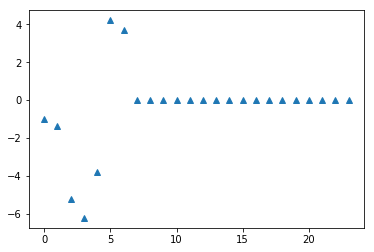

In [19]:
itr_list = [list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list()]
for j in range(0,100):
    random.shuffle(allData)
    halfData = Data12[:len(allData)/5]

    totalPredictedTime = [0] * 24
    totalWaitTime = [0] * 24
    numberOfTickets = [0] * 24

    for line in halfData:
        if len(line["tutors_on_duty"]) == 0:
            totalPredictedTime[int(line['day_of_week'])] += 6.0 * (line["position"] * 1.0) + 9.3
        else:
            totalPredictedTime[int(line['day_of_week'])] += 6.0 * (line["position"] * 1.0 / len(line["tutors_on_duty"])) + 9.3
        totalWaitTime[int(line['day_of_week'])] += line['diff'] * 1.0 / (60 * 1000)
        numberOfTickets[int(line['day_of_week'])] += 1
    
    for i in range(0,24):
        if numberOfTickets[i] == 0:
            itr_list[i].append(0)
        else:
            itr_list[i].append((totalWaitTime[i] * 1.0 / numberOfTickets[i])
                           - (totalPredictedTime[i] * 1.0 / numberOfTickets[i]))

avgErr = [0] * 24
stdErr = [0] * 24        
for l in range(0,24):
    stdErr[l] = np.std(np.array(itr_list[l]))
    avgErr[l] = np.mean(np.array(itr_list[l]))
dayOfWeek = range(0,24)
print avgErr
print stdErr

plt.errorbar(dayOfWeek, avgErr, stdErr, linestyle='None', marker='^')
plt.show()




In [20]:
itr_list = [list(),list(),list(),list(),list()
            ,list(),list()
           ]
for j in range(0,100):
    random.shuffle(Data100)
    halfData = Data100[:len(Data100)/5]

    totalPredictedTime = [0] * 7
    totalWaitTime = [0] * 7
    numberOfTickets = [0] * 7

    for line in halfData:
        if line['position'] >= 7:
            continue
           
        if  int(line['day_of_week']) == 0:
            totalPredictedTime[int(line['day_of_week'])] += predict_lstsq(thetaQ, getFeatures([line]))[0] + 3.5
        else:
            totalPredictedTime[int(line['day_of_week'])] += predict_lstsq(thetaQ, getFeatures([line]))[0]
        totalWaitTime[int(line['day_of_week'])] += line['diff'] * 1.0 / (60 * 1000)
        numberOfTickets[int(line['day_of_week'])] += 1
    
    for i in range(0,7):
        if numberOfTickets[i] == 0:
            itr_list[i].append(0)
        else:
            itr_list[i].append((totalWaitTime[i] * 1.0 / numberOfTickets[i])
                           - (totalPredictedTime[i] * 1.0 / numberOfTickets[i]))

avgErr = [0] * 7
stdErr = [0] * 7        
for l in range(0,7):
    stdErr[l] = np.std(np.array(itr_list[l]))
    avgErr[l] = np.mean(np.array(itr_list[l]))
dayOfWeek = range(0,7)
# print avgErr
# print stdErr

plt.errorbar(dayOfWeek, avgErr, stdErr, linestyle='None', marker='^')
plt.show()


NameError: name 'predict_lstsq' is not defined

In [ ]:
# Graphs to explore aspects of the data

In [ ]:
# Plot time it takes to resolve a ticket
itr_list = [list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list() 
           ]



numberOfTickets = [0] * 90
for line in Data100:
    if line['time_to_resolve'] == None or int(line['time_to_resolve'] / (60*1000)) >= 90:
        continue
    numberOfTickets[int(line['time_to_resolve'] / (60*1000))] += 1
    
plt.errorbar(range(0,90), numberOfTickets)
plt.show()


In [ ]:
# Plot wait
itr_list = [list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(),list()
            ,list(),list(),list(),list(), list()
            ,list(),list(),list(),list(), list()
           ]



numberOfTickets = [0] * 180
for line in allData:
    if line['diff'] == None or int(line['diff'] / (60*1000)) >= 180:
        continue
    numberOfTickets[int(line['diff'] / (60*1000))] += 1
    
plt.errorbar(range(0,180), numberOfTickets)
plt.show()

In [ ]:
resTime = list()
for line in allData:
    if line['time_to_resolve'] != None:
        resTime.append(line['time_to_resolve'])
        
print np.std(np.array(resTime)) /(60*1000)
print np.mean(np.array(resTime)) /(60*1000)

In [ ]:
allData[0]

In [ ]:
# Graph the number of tickets each tutor has helped
tutorsResTime = defaultdict(int)
tutorsTicketCount = defaultdict(int)

for line in allData:
    if line['time_to_resolve'] != None:
        tutorsResTime[line['tutor_id']] += line['time_to_resolve']
        tutorsTicketCount[line['tutor_id']] += 1
    
plt.scatter([key for key in tutorsTicketCount], [tutorsTicketCount[key] for key in tutorsTicketCount])
plt.show()

In [ ]:
# Count the number of tickets a tutor has helped
count = 0
tcount = 0
tutorTickCount = defaultdict(int)
for line in allData:
    if line['time_to_resolve'] != None:
        tutorTickCount[line['tutor_id']] += 1

for tutor in tutorTickCount:
    tcount += 1
    if tutorsTicketCount[tutor] > 10:
        count += 1

print count
print tcount

In [ ]:
# Methods for getting features, labels, predictions, and models

In [21]:
def Course_Array(course):
    code = int(re.search(r'\d+', course).group())
    return {
        8: [1,0,0,0,0,0],
        11: [0,1,0,0,0,0],
        12: [0,0,1,0,0,0],
        30: [0,0,0,1,0,0],
        100: [0,0,0,0,1,0]
    }.get(code, [0,0,0,0,0,1])

def Course_Idx(course):
    code = int(re.search(r'\d+', course).group())
    return {
        8: 0,
        11: 1,
        12: 2,
        30: 3,
        100: 4
    }.get(code, 5)

In [22]:
def getFeatures(data):
    NUMBER_OF_COURSES = 6
    features = list()
    for line in data:
        
    # Get the estimated time per ticket -----------------------------------------------------------
        position = line['position']
        num_tutors = len(line['tutors_on_duty'])
        recent_ticket_time = line['avg_daily_res_time'] * 1.0 / (60*1000)
        if num_tutors == 0:
            num_tutors = 1
        sumVal = 0
        count = 0
        for tutor in line['tutors_on_duty']:
            if tutor in tutorStats:
                sumVal += tutorStats[tutor]
                count += 1
        if count > 0:
            tutor_bias = sumVal * 1.0 / count
        else:
            tutor_bias = 1.0
        
        time_per_ticket = [position * tutor_bias * recent_ticket_time / num_tutors] * NUMBER_OF_COURSES
        time_per_ticket_c = [a*b for a,b in zip(time_per_ticket, Course_Array(line['course']))]
    # -----------------------------------------------------------------------------------------------
    
    # Get position ----------------------------------------------------------------------------------
        position = [int(position)] * NUMBER_OF_COURSES
        position_c = [a*b for a,b in zip(position, Course_Array(line['course']))]
    # -----------------------------------------------------------------------------------------------
    
    # Get Number of Tutors --------------------------------------------------------------------------
        num_tutors = [num_tutors] * NUMBER_OF_COURSES
        num_tutors_c = [a*b for a,b in zip(num_tutors, Course_Array(line['course']))]
    # -----------------------------------------------------------------------------------------------
    
    # Get Day of the Week ---------------------------------------------------------------------------
#         day_of_week_c = [0] * 7 * NUMBER_OF_COURSES
#         day = int(line['day_of_week'])
#         course = Course_Idx(line['course'])
#         day_of_week_c[(7 * course) + day] = 1
    # -----------------------------------------------------------------------------------------------
    
    # If daily ticket count is greater than 5 then avg time to resolve for today --------------------
        
            
        features.append(time_per_ticket_c + position_c + num_tutors_c + [1])

    return features

def getFeaturesNN(data):
    features = list()
    for line in data:
        
        #position z-scored
        position = [(line['position']-5) * 1.0 / 10]
        
        #recent_ticket_time z-scored
        recent_ticket_time = [(line['avg_daily_res_time'] * 1.0 / (60*1000) - 12) * 1.0 / 15]

        #Number of tutors z-scored
        num_tutors = len(line['tutors_on_duty'])
        if num_tutors == 0:
            num_tutors = 1
        num_tutors = [(num_tutors - 3) * 1.0 / 3]
        
        #Tutor Bias (no need for z-scoring)
        sumVal = 0
        count = 0
        for tutor in line['tutors_on_duty']:
            if tutor in tutorStats:
                sumVal += tutorStats[tutor]
                count += 1
        if count > 0:
            tutor_bias = sumVal * 1.0 / count
        else:
            tutor_bias = 1.0
        tutor_bias = [tutor_bias]

        # Day of Week one hot
#         day_of_week = [0] * 7
#         day = int(line['day_of_week'])
#         day_of_week[day] = 1
        
        # Course one hot
        course = [0] * 6
        courseIdx = Course_Idx(line['course'])
        course[courseIdx] = 1
           
            
        features.append(position + num_tutors + day_of_week + tutor_bias + course + [1])

    return features

def getBasicFeatures(data):
    features = list()
    for line in data:
        position = line['position']
        num_tutors = len(line['tutors_on_duty'])
        if num_tutors == 0:
            num_tutors = 1
        time_per_ticket = [position * 1.0 / num_tutors]
        
        features.append(time_per_ticket+[1])
    return features
        
def getLabels(data):
    labels = list()
    for line in data:
        labels.append(line['diff'] * 1.0 / (60 * 1000))
    return labels

In [23]:
# Returns a multi-level perceptron that has the same number of parameters
# as the lstsq model
def GetModel():
    sgd = SGD(lr=0.001, momentum=0.9, decay=0.005, nesterov=True)
    model = Sequential()
    model.add(Dense(3, input_dim=6, init='normal', activation='tanh'))
    model.add(Dense(1, init='normal'))
    
    model.compile(loss='mean_squared_error',optimizer=sgd)
    return model

In [24]:
# Takes a list of features and the least squares coefficients and returns a list of predicted wait times
def predict_lstsq(coefficients, features):
    return [sum(np.multiply(coefficients, feat)) for feat in features]

# Takes a multi level perceptron and a list of features and returns a list of predicted wait times
def predict_nn(model, features):
    features = np.array(features)
    return model.predict(features, batch_size=10)
    

In [25]:
count = 0
for line in allData:
    count += line['diff'] / (60*1000)
    
print count / len(allData)

21


In [26]:
# Split data and train models

In [28]:
random.shuffle(allData)
train = allData[:(len(allData)/2)]
valadation = allData[(len(allData)/2):]

features = getFeatures(train)
labels = getLabels(train)

# featuresNN = getFeaturesNN(train)

features_v = getFeatures(valadation)
# featuresNN_v = getFeaturesNN(valadation)
labels_v = getLabels(valadation)

In [29]:
# def train_nn(features, labels):
#     features = np.array(features)
#     labels = np.array(labels)
#     model = GetModel()
#     model.fit(features, labels, batch_size=10, nb_epoch=15, verbose=1
#              , shuffle=True)
#     return model

In [36]:
theta, residuals,rank,s = np.linalg.lstsq(features, labels)
#model = train_nn(featuresNN ,labels)

In [38]:
len(theta)

19

In [ ]:
# Exploring how the models work

In [31]:
# Print out theta weights
for idx, weight in enumerate(theta):
    if idx % 6 == 0:
        print ' '
    if idx < 6:
        print str(idx % 6) + ' its wait time is ' + str(weight)
    if idx >= 6 and idx < 12:
        print str(idx % 6) + ' its position is ' + str(weight)
    if idx >= 12 and idx < 18:
        print str(idx % 6) + ' its num_tutors is ' + str(weight)


 
0 its wait time is 21.9819548594


In [ ]:
# # Prints out the weights of the nn model
# weights = model.get_weights()

# print weights

In [ ]:
# Evaluating models

In [39]:
#predNN = predict_nn(model, featuresNN_v)
pred = predict_lstsq(theta, features_v)

In [40]:
# Cal MAE for Task3
def calc_MSE(predicted, labels):
    err = [int((pred - label)**2) for pred, label in zip(predicted, labels)]
#     count = [0]* max(err)
#     for ticket in err:
#         count[ticket] += 1
    
    
#     plt.scatter(range(0,max(err)), count)
#     plt.show()
    
    
    print "Mean Squared Error = " + str(np.mean(err))
    print "Standard Deviation = " + str(np.std(err))

In [41]:
def calc_BinError(predicted, labels):
    offByALittle = 0
    offByALot = 0
    total = 0
    for idx in range(0,len(labels)):
        total += 1
        label = labels[idx]
        pred = predicted[idx]
        if label <= 10:
            if abs(pred - label) > 20:
                offByALot += 1
            if abs(pred - label) > 10:
                offByALittle += 1
        elif label <= 30:
            if abs(pred - label) > 20:
                offByALot += 1
            if abs(pred - label) > 10:
                offByALittle += 1
        elif label <= 60:
            if abs(pred - label) > 30:
                offByALot += 1
            if abs(pred - label) > 15:
                offByALittle += 1
        elif label <= 120:
            if abs(pred - label) > 60:
                offByALot += 1
            if abs(pred - label) > 30:
                offByALittle += 1
    print "Percent of predictions that are off by a little: " + str(offByALittle * 1.0 / total)
    print "Percent of predictions that are off by a lot: " + str(offByALot * 1.0 / total)
    print "Total number of predictions: " + str(total)

In [42]:
print "Performace of lstsq model"
print "-------------------------"
calc_BinError(pred, labels_v)
calc_MSE(pred, labels_v)
# print ' '
# print "Performace of nn model"
# print "-------------------------"
# calc_BinError(predNN, labels_v)
# calc_MSE(predNN, labels_v)

Performace of lstsq model
-------------------------
Percent of predictions that are off by a little: 0.237699468085
Percent of predictions that are off by a lot: 0.0412603427896
Total number of predictions: 27072
Mean Squared Error = 247.170840721
Standard Deviation = 778.089853846
